# Training v4 - comprehensive assessment

filter -> wrapper -> model -> cross validation -> evaluation

In [37]:
# load in data

import pandas as pd
import pickle

with open('data/gdsc.pkl', 'rb') as f:
    gdsc1 = pickle.load(f)
    gdsc1_drugdata = pickle.load(f)
    gdsc2 = pickle.load(f)
    gdsc2_drugdata = pickle.load(f)

with open('data/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

with open('data/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

with open('data/preprocessed/processed_data2.pkl', 'rb') as f:
    xtrain = pickle.load(f)
    ylabel = pickle.load(f)
    ylabel_binary = pickle.load(f)
    index_to_sanger = pickle.load(f)

palbo = gdsc1.loc[gdsc1['DRUG_NAME'] == 'Palbociclib']
ln_ic50 = palbo['LN_IC50']
celllines = palbo['SANGER_MODEL_ID']

no_og_features = len(gene_entrez)-1

In [38]:
print(xtrain[1,:].shape)

(19221,)


### Filter on target (Spearmanr)

In [39]:
from scipy.stats import f, spearmanr
import numpy as np


# spearman r feature selection

def spearmanr_feature_selection(x, y, corr_threshold=0.1, p_threshold=0.05):

    # calculate spearman correlation
    spearmanr_list = []
    for i in range(len(x[0])):
        spearmanr_list.append(spearmanr(x[:, i], y)[0])

    # sort spearman correlation
    spearmanr_list = np.array(spearmanr_list)
    spearmanr_list = np.argsort(spearmanr_list)
    spearmanr_list = spearmanr_list[::-1]

    # select top k features
    x_new = []
    for i in range(len(x)):
        x_new.append([])
        for j in range(k):
            x_new[i].append(x[i][spearmanr_list[j]])

    return x_new


In [40]:

# selectKBest using f-classif

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k_val = 1000

xtrain_k = SelectKBest(f_classif, k=k_val).fit_transform(xtrain, ylabel_binary)



c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 1771 14517 15372 15411 16982 17762 17858 17979 18012 18014 19153] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [41]:
from random import shuffle


test_size = 100

shuffle(xtrain_k)
shuffle(ylabel)

x_test = xtrain_k[:test_size]
partial_x_train = xtrain_k[test_size:]

y_test = ylabel_binary[:test_size]
partial_y_train = ylabel_binary[test_size:]


In [42]:
from keras import models
from keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

def create_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(k_val,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model 


### Wrapper 

In [43]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = xtrain_k, ylabel_binary
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.478 (0.063)


## Test data evaluation

In [44]:
# import matplotlib.pyplot as plt
model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
model.fit(partial_x_train, partial_y_train, epochs=100, batch_size=10, verbose=0)
test_pred = model.predict(x_test)

print(test_pred)
print(y_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1.]


Accuracy:  0.43
AUC:  0.5


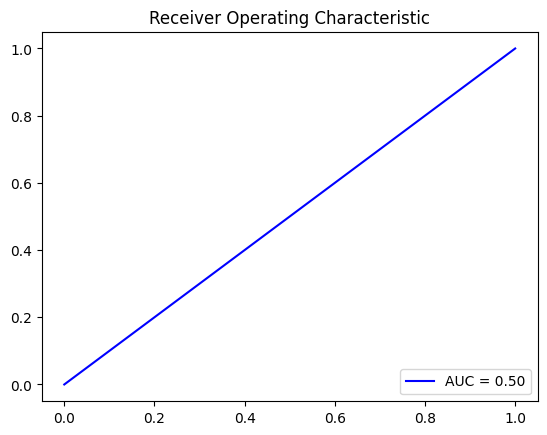

In [45]:
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt

acc = metrics.accuracy_score(y_test, test_pred)
print("Accuracy: ", acc)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)

roc_auc = metrics.auc(fpr, tpr)
print("AUC: ", roc_auc)



# Plot ROC 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()
